In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter 

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity

import numpy as np
from collections import OrderedDict
from collections import namedtuple
from itertools import product
import statistics

import sklearn.metrics as met

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline


In [65]:
# Download the data
# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

val_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

In [28]:
# Define what labels mean
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

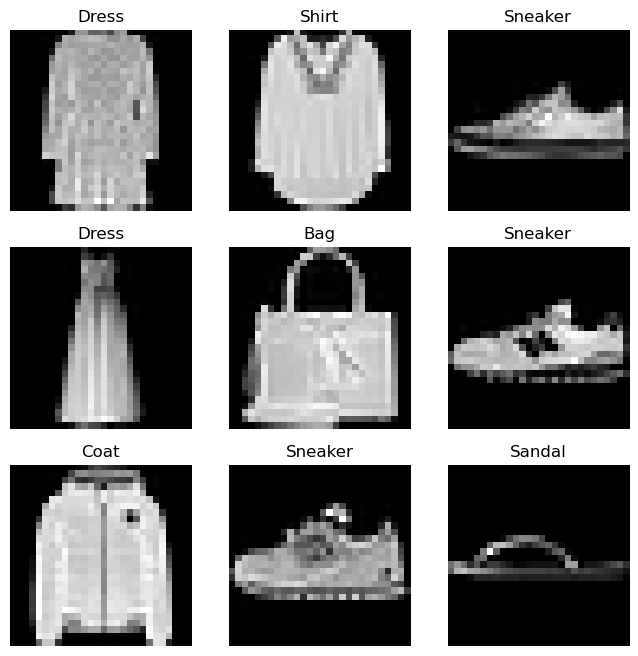

In [29]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [8]:
class SimpleVision(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, x):
        # run the conv layers
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2)
        
        # flatten
        x = x.reshape(-1, 12*4*4)
        
        # run linear layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # generate output
        x = self.out(x)
        
        return x


In [11]:
# set up hyperparams for sweep

params = OrderedDict(
    lr = [.01, .001],
    batch_size = [100, 1000],
    shuffle = [True, False]
)
epochs = 3

In [55]:
loader = torch.utils.data.DataLoader(train_set, batch_size = 100)
model = SimpleVision()
optimizer = optim.Adam(model.parameters(), lr = .001)

In [56]:
training_logs = {}

for epoch in range(epochs):
    print(f"Epoch {epoch}/{epochs}:")

    losses = []
    for batch in loader:
        X = batch[0]; y = batch[1]

        preds = model(X)
        loss = F.cross_entropy(preds, y); losses.append(float(loss))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    training_logs[epoch] = losses


Epoch 0/3:
Epoch 1/3:
Epoch 2/3:


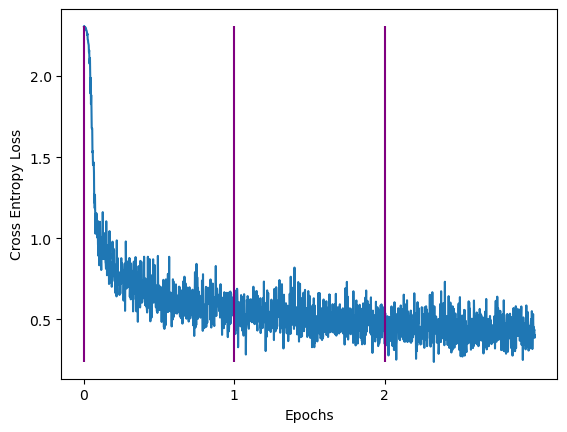

In [64]:
all_logs = []
epoch_lens = []
for epoch in training_logs.keys():
    all_logs.extend(training_logs[epoch])
    epoch_lens.append(len(training_logs[epoch])*epoch)

plt.plot(all_logs)
plt.xticks(epoch_lens, [0, 1, 2])
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")

plt.vlines(x=epoch_lens, ymin=min(all_logs), ymax=max(all_logs), colors='purple')


In [66]:
val_set

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data/FashionMNIST
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [71]:
val_loader = torch.utils.data.DataLoader(train_set, batch_size = 100)

In [79]:
# Make predictions on the validaiton set

y_all = []; pred_all = []
for batch in val_loader:
    X = batch[0]; y = batch[1]

    preds = model(X)
    binary_preds = np.argmax(preds.detach().numpy(), axis=1)
    pred_all.extend(binary_preds)
    y_all.extend(y.detach().numpy())
    

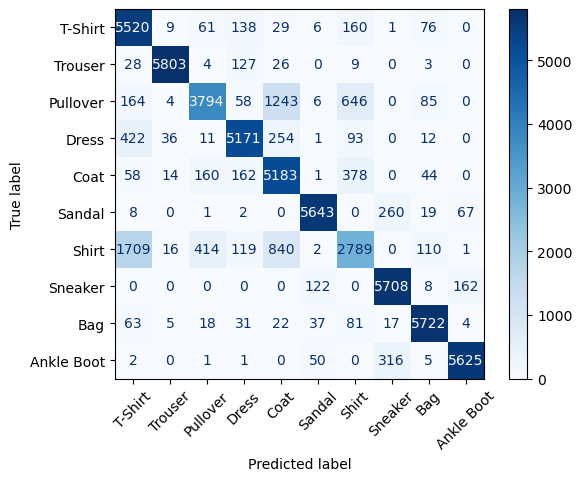

In [95]:
disp = met.ConfusionMatrixDisplay(confusion_matrix=met.confusion_matrix(y_all, pred_all), display_labels=labels_map.values())
disp.plot(xticks_rotation=45, cmap='Blues')

<Axes: >

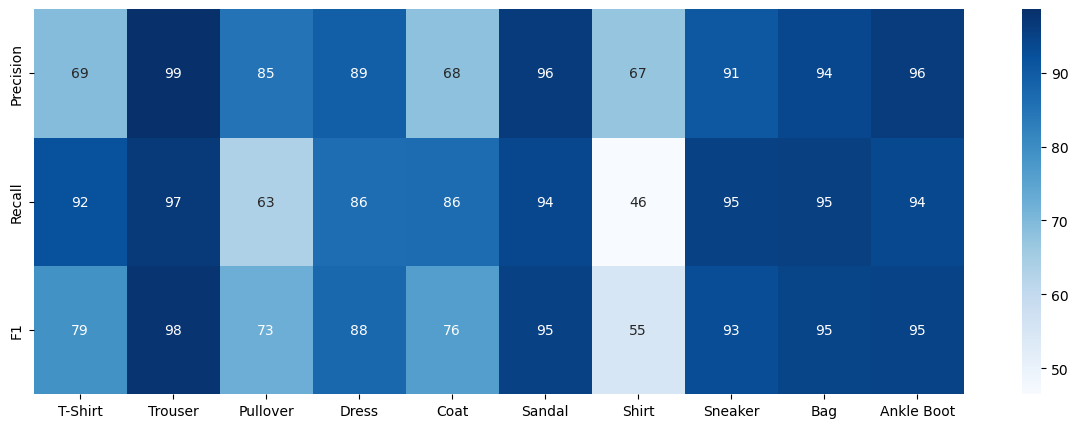

In [106]:
plt.figure(figsize=(15, 5))
sns.heatmap(np.stack(met.precision_recall_fscore_support(y_all, pred_all)[0:3])*100, annot=True, cmap='Blues', xticklabels=labels_map.values(), 
    yticklabels=['Precision', 'Recall', 'F1'], )